# Interactive Learning Course
## HW #2, Multi-Armed Bandits

In [71]:
import numpy as np
from abc import ABC, abstractmethod
import gym
import matplotlib.pyplot as plt
import random

# Part 2

## Reward class

In [72]:
class Reward(ABC):
    def __init__(self, debts=[5, 20, 100]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [73]:
class Student(Reward):   #id = 1
    def __init__(self):
        super(Student, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6]) 
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1]) 
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05]) 
        
        return obs, obs - self.debts[action]

In [74]:
s = Student()
s.get_reward(1)[1]

-15.0

In [75]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])
        
        return obs, obs - self.debts[action]

In [76]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])
        
        return obs, obs - self.debts[action]

In [77]:
s = SelfEmp()
s.get_reward(2)

(80, -20)

## Environment

In [78]:
class Environment:
    def __init__(self, id, reward = 1):  # reward?
        ## YOUR CODES ##
        self.id = id
        self.reward = reward
    
    def calc_reward(self, action):
        agent = self.id()
        r = agent.get_reward(action)
        return r
    

    def get_available_actions(self):
        return 3

# Part 3

In [79]:
class Agent_epsilonGreedy():

    def __init__(self, id, env, alpha=0, beta=1, gamma=1, lr = 0.001, eps = 0.2):

        self.id = id
        self.env = env    
        self.lr = lr
        self.eps = eps
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.available_actions = env.get_available_actions()
        self.action_counts = [0 for i in range(self.available_actions)]
        self.QValues = [0 for i in range(self.available_actions)] 

    def select_action(self):

        #p = random.random()
        #if p< self.eps:
            #return np.argmax(self.QValues)
        #else:
            #return np.random.choice(self.available_actions)

        policy = [np.argmax(self.QValues), np.random.randint(0, self.available_actions) ]
        action = np.random.choice(policy, 1, p=[self.eps, (1-self.eps)])
        return action[0]

    def calculate_utility(self, reward):
        utility = self.beta * reward**self.gamma + self.alpha
        return utility

    def update(self, action, r):

        self.QValues[action] = self.QValues[action] * self.action_counts[action] + r
        self.action_counts[action] += 1
        self.QValues[action] = self.QValues[action]/self.action_counts[action]

    def take_action(self):
        action = self.select_action()
        r = self.take_rewards(action)
        self.update(action, r)
        regret = self.get_regrets()
        return r

    def take_rewards(self,action):
      return self.env.calc_reward(action)[1]

    def get_regrets(self):
        rewards = np.zeros([3,1000])
        for i in range(1000):
          rewards[0][i] = (self.take_rewards(0))
          rewards[1][i] = (self.take_rewards(1))
          rewards[2][i] = (self.take_rewards(2))
        
        mean_r = np.mean(rewards, axis = 1)
        a_star = np.argmax(mean_r)
        q_a_star = mean_r[a_star]


        return q_a_star 


        

In [81]:
class Agent_UCB():
    def __init__(self, id, env, C, alpha = 0, beta = 1, gamma = 1): 


        self.id = id
        self.env = env  
        self.c = C  
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.available_actions = env.get_available_actions()
        self.Nt = [0 for i in range(self.available_actions)]
        self.QValues = [0 for i in range(self.available_actions)] 
        
        self.C = 1

    def calculate_utility(self, reward):
        utility = self.beta * reward**self.gamma + self.alpha
        return utility

    def select_action(self):


        UCB = []
        for i in range(self.available_actions):
          if self.Nt[i] != 0 :
            UCB.append(self.QValues[i] + self.c * np.sqrt(np.log(np.sum(self.Nt)/self.Nt[i])))
          else:
            UCB.append(np.inf)

        return np.argmax(np.array(UCB))

    def update(self, action, r):

        self.QValues[action] = self.QValues[action] * self.Nt[action] + r
        self.Nt[action] = self.Nt[action] + 1
        self.QValues[action] = self.QValues[action]/self.Nt[action]

    def take_action(self):
        action = self.select_action()
        r = self.take_rewards(action)
        self.update(action, r)
        return r

    def take_rewards(self,action):
      return self.env.calc_reward(action)[1]

    def get_regrets(self):
        rewards = np.zeros([3,1000])
        for i in range(1000):
          rewards[0][i] = (self.take_rewards(0))
          rewards[1][i] = (self.take_rewards(1))
          rewards[2][i] = (self.take_rewards(2))
        
        mean_r = np.mean(rewards, axis = 1)
        a_star = np.argmax(mean_r)
        q_a_star = mean_r[a_star]


        return q_a_star 


In [82]:
class Agent_Griadient():
    def __init__(self, id, env, lr = 0.001, alpha = 0, beta = 1, gamma = 1) : 


        self.id = id
        self.env = env 
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.lr = lr
        self.available_actions = env.get_available_actions()
        self.mean_r = 0
        self.t = 0
        self.H = [0 for i in range(self.available_actions)] 
        


    def calculate_utility(self, reward):
        utility = self.beta * reward**self.gamma + self.alpha
        return utility

    def select_action(self):

        d = np.sum(np.exp(self.H))
        return np.random.choice(a = [i for i in range(len(self.H))], p = np.exp(self.H)/d)

    def update(self, action, r):

        d = np.sum(np.exp(self.H))
        self.H = self.H - self.lr * (r - self.mean_r) * np.exp(self.H)/d
        self.H[action] = self.H[action] + self.lr * (r - self.mean_r)
        self.mean_r = self.mean_r * self.t + r
        self.t = self.t + 1
        self.mean_r = self.mean_r/ self.t
        #return H

    def take_action(self):

        action = self.select_action()
        r = self.take_rewards(action)
        self.update(action, r)

        return r

    def take_rewards(self,action):
      return self.env.calc_reward(action)[1]

    def get_regrets(self):
        rewards = np.zeros([3,1000])
        for i in range(1000):
          rewards[0][i] = (self.take_rewards(0))
          rewards[1][i] = (self.take_rewards(1))
          rewards[2][i] = (self.take_rewards(2))
        
        mean_r = np.mean(rewards, axis = 1)
        a_star = np.argmax(mean_r)
        q_a_star = mean_r[a_star]


        return q_a_star 


## Rewards and regrets

### epsilon greedy

In [83]:
def mean_reward_epsilon(id, epoch, trial ): #Student , 20, 1000
  epoch_rewards = []
  epoch_regret = []

  id = id  #id
  env = Environment(id, 1) 
  agent = Agent_epsilonGreedy(id, env)
  QStar = agent.get_regrets()
  for e in range(epoch): #epoch
      reward = []
      regret = []
      for i in range(trial): #trial
        r = agent.take_action()
        reward.append(r)
        regret.append((i+1) * QStar - np.sum(reward))
      epoch_rewards.append(reward)
      epoch_regret.append(regret)
  mean_reward = np.mean(epoch_rewards,axis = 0)
  mean_regret = np.mean(epoch_regret, axis = 0)
  cum_reward = np.cumsum(mean_reward)
  #cum_regret = np.cumsum(mean_regret)
  for i in range(len(cum_reward)):
    cum_reward[i] = cum_reward[i]/(i+1)
    #cum_regret[i] = cum_regret[i]/(i+1)
  return cum_reward, mean_regret

### Griadient

In [84]:
def mean_reward_Griadient(id, epoch, trial, lr=0.001): #Student , 20, 1000
  epoch_rewards = []
  epoch_regret = []

  id = id  #id
  env = Environment(id, 1) 
  agent = Agent_Griadient(id, env, lr)
  QStar = agent.get_regrets()

  for e in range(epoch): #epoch
      reward = []
      regret = []
      for i in range(trial): #trial
        r = agent.take_action()
        reward.append(r)
        regret.append((i+1) * QStar - np.sum(reward))
      epoch_rewards.append(reward)
      epoch_regret.append(regret)
  mean_reward = np.mean(epoch_rewards,axis = 0)
  mean_regret = np.mean(epoch_regret, axis = 0)
  cum_reward = np.cumsum(mean_reward)
  for i in range(len(cum_reward)):
    cum_reward[i] = cum_reward[i]/(i+1)
  return cum_reward, mean_regret

### UCB

In [85]:
def mean_reward_UCB(id, epoch, trial, C): #Student , 20, 1000
  epoch_rewards = []
  epoch_regret = []


  id = id  #id
  env = Environment(id, 1) 
  agent = Agent_UCB(id, env, C)
  QStar = agent.get_regrets()

  for e in range(epoch): #epoch
      reward = []
      regret = []
      for i in range(trial): #trial
        r = agent.take_action()
        reward.append(r)
        regret.append((i+1) * QStar - np.sum(reward))
      epoch_rewards.append(reward)
      epoch_regret.append(regret)
  mean_reward = np.mean(epoch_rewards,axis = 0)
  mean_regret = np.mean(epoch_regret, axis = 0)
  cum_reward = np.cumsum(mean_reward)
  for i in range(len(cum_reward)):
    cum_reward[i] = cum_reward[i]/(i+1)
  return cum_reward, mean_regret

## Resualt of Enviorments

### Student

In [86]:
#Student
id = Student
m,  regret = mean_reward_epsilon(id, 20, 100) #id, epoch, trial
m2, regret2 = mean_reward_UCB(id, 20, 100,2) #id, epoch, trial, C
m3, regret3 = mean_reward_Griadient(id, 20, 100) #id, epoch, trial, C

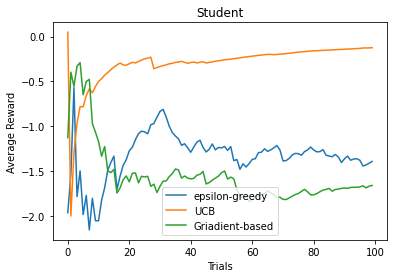

In [104]:
plt.plot(m)
plt.plot(m2)
plt.plot(m3)
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('Student')
plt.legend(['epsilon-greedy', 'UCB', 'Griadient-based'])

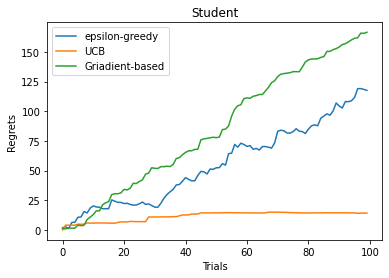

In [105]:
plt.plot(regret)
plt.plot(regret2)
plt.plot(regret3)
plt.xlabel('Trials')
plt.ylabel('Regrets')
plt.title('Student')
plt.legend(['epsilon-greedy', 'UCB', 'Griadient-based'])

### GavStaff

In [115]:
#GovStaff
id = GovStaff
m,  regret = mean_reward_epsilon(id, 20, 100) #id, epoch, trial
m2, regret2 = mean_reward_UCB(id, 20, 100,2) #id, epoch, trial, C
m3, regret3 = mean_reward_Griadient(id, 20, 100) #id, epoch, trial, C

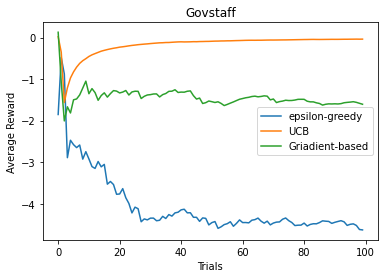

In [116]:
plt.plot(m)
plt.plot(m2)
plt.plot(m3)
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('Govstaff')
plt.legend(['epsilon-greedy', 'UCB', 'Griadient-based'])

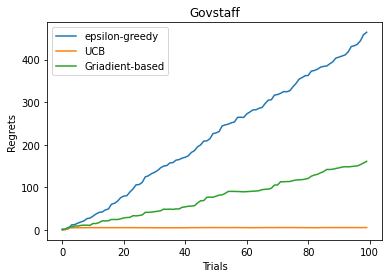

In [117]:
plt.plot(regret)
plt.plot(regret2)
plt.plot(regret3)
plt.xlabel('Trials')
plt.ylabel('Regrets')
plt.title('Govstaff')
plt.legend(['epsilon-greedy', 'UCB', 'Griadient-based'])

### SelfEmp

In [92]:
#SelfEmp
id = SelfEmp

m,  regret = mean_reward_epsilon(id, 20, 100) #id, epoch, trial
m2, regret2 = mean_reward_UCB(id, 20, 100,2) #id, epoch, trial, C
m3, regret3 = mean_reward_Griadient(id, 20, 100) #id, epoch, trial, C

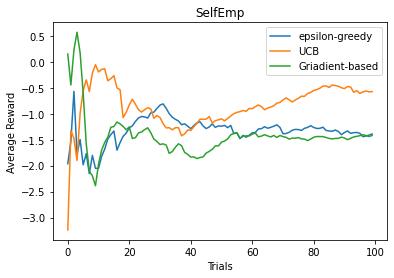

In [93]:
plt.plot(m)
plt.plot(m2)
plt.plot(m3)
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('SelfEmp')
plt.legend(['epsilon-greedy', 'UCB', 'Griadient-based'])

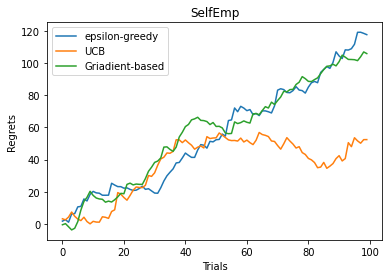

In [94]:
plt.plot(regret)
plt.plot(regret2)
plt.plot(regret3)
plt.xlabel('Trials')
plt.ylabel('Regrets')
plt.title('SelfEmp')
plt.legend(['epsilon-greedy', 'UCB', 'Griadient-based'])

# Part5

## Student

In [95]:
#Student
id = Student

m1, regret1 = mean_reward_Griadient(id, 20, 100, 0.1) #id, epoch, trial, C
m2, regret2 = mean_reward_Griadient(id, 20, 100, 0.02) #id, epoch, trial, C
m3, regret3 = mean_reward_Griadient(id, 20, 100, 0.001) #id, epoch, trial, C
m4, regret4 = mean_reward_Griadient(id, 20, 100, 0.008) #id, epoch, trial, C

Text(0.5, 1.0, 'Student')

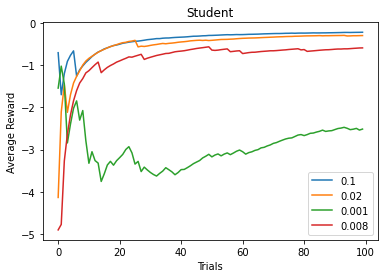

In [96]:
plt.plot(m1)
plt.plot(m2)
plt.plot(m3)
plt.plot(m4)
plt.legend(['0.1', '0.02', '0.001', '0.008'])
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('Student')

Text(0.5, 1.0, 'Student')

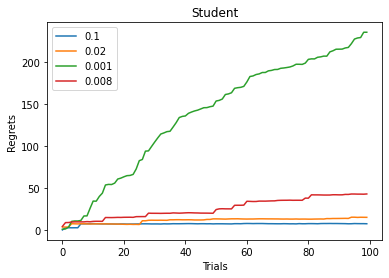

In [97]:
plt.plot(regret1)
plt.plot(regret2)
plt.plot(regret3)
plt.plot(regret4)
plt.legend(['0.1', '0.02', '0.001', '0.008'])
plt.xlabel('Trials')
plt.ylabel('Regrets')
plt.title('Student')

## SelfEmp

In [98]:
#SelfEmp
id = SelfEmp

m1, regret1 = mean_reward_Griadient(id, 20, 100, 0.1) #id, epoch, trial, C
m2, regret2 = mean_reward_Griadient(id, 20, 100, 0.02) #id, epoch, trial, C
m3, regret3 = mean_reward_Griadient(id, 20, 100, 0.001) #id, epoch, trial, C
m4, regret4 = mean_reward_Griadient(id, 20, 100, 0.008) #id, epoch, trial, C

Text(0.5, 1.0, 'SelfEmp')

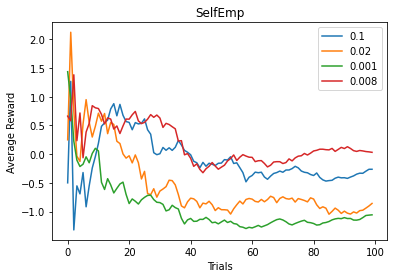

In [99]:
plt.plot(m1)
plt.plot(m2)
plt.plot(m3)
plt.plot(m4)
plt.legend(['0.1', '0.02', '0.001', '0.008'])
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('SelfEmp')

Text(0.5, 1.0, 'SelfEmp')

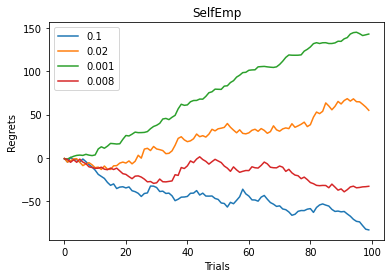

In [100]:
plt.plot(regret1)
plt.plot(regret2)
plt.plot(regret3)
plt.plot(regret4)
plt.legend(['0.1', '0.02', '0.001', '0.008'])
plt.xlabel('Trials')
plt.ylabel('Regrets')
plt.title('SelfEmp')

## GovStaff

In [101]:
#GovStaff
id = GovStaff

m1, regret1 = mean_reward_Griadient(id, 20, 100, 0.1) #id, epoch, trial, C
m2, regret2 = mean_reward_Griadient(id, 20, 100, 0.02) #id, epoch, trial, C
m3, regret3 = mean_reward_Griadient(id, 20, 100, 0.001) #id, epoch, trial, C
m4, regret4 = mean_reward_Griadient(id, 20, 100, 0.008) #id, epoch, trial, C

Text(0.5, 1.0, 'GovStaff')

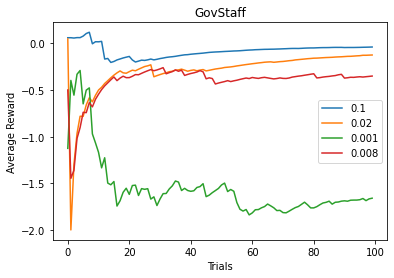

In [102]:
plt.plot(m1)
plt.plot(m2)
plt.plot(m3)
plt.plot(m4)
plt.legend(['0.1', '0.02', '0.001', '0.008'])
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('GovStaff')

Text(0.5, 1.0, 'GovStaff')

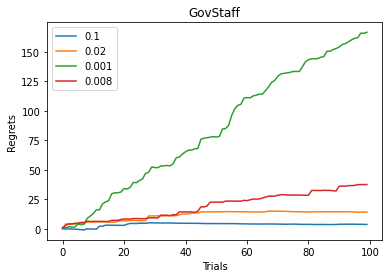

In [103]:
plt.plot(regret1)
plt.plot(regret2)
plt.plot(regret3)
plt.plot(regret4)
plt.legend(['0.1', '0.02', '0.001', '0.008'])
plt.xlabel('Trials')
plt.ylabel('Regrets')
plt.title('GovStaff')